In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import beta

In [108]:
df = pd.read_csv('AB_Test_Results.csv')
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


,USER_ID,VARIANT_NAME,REVENUE
9138,6331,variant,0.0
1789,9766,control,0.0
9292,8708,variant,0.0
4537,604,control,0.0
7814,763,control,0.0
1246,6762,control,0.0
673,2687,control,0.0
7131,7659,variant,0.0
7448,1587,variant,0.0
1448,9327,variant,0.0


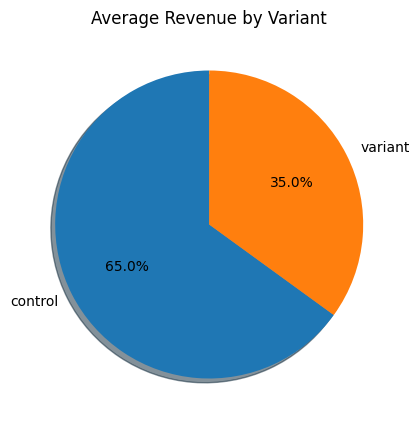

In [109]:
#get average revenue by variant, format the number to 2 decimal places
avg_revenue = df.groupby('VARIANT_NAME')['REVENUE'].mean().round(2)
avg_revenue.head()

#plot pie chart
plt.figure(figsize=(5,5))
plt.pie(avg_revenue, labels=avg_revenue.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Average Revenue by Variant')
plt.show()

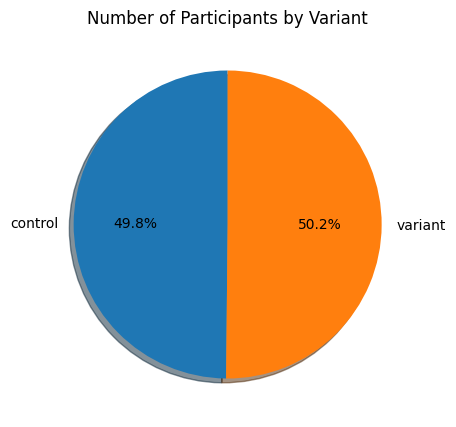

In [110]:
number_of_participants = df.groupby('VARIANT_NAME').count()['USER_ID']

#plot chart for number of participants
plt.figure(figsize=(5,5))
plt.pie(number_of_participants, labels=number_of_participants.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Number of Participants by Variant')
plt.show()

In [111]:
#add a new column 'CONVERSION' , if 'REVENUE' is 0 then 'CONVERSION' is 0, else 1
df['CONVERSION'] = df['REVENUE'].apply(lambda x: 0 if x == 0 else 1)
df.head() 

,USER_ID,VARIANT_NAME,REVENUE,CONVERSION
0,737,variant,0.0,0
1,2423,control,0.0,0
2,9411,control,0.0,0
3,7311,control,0.0,0
4,6174,variant,0.0,0


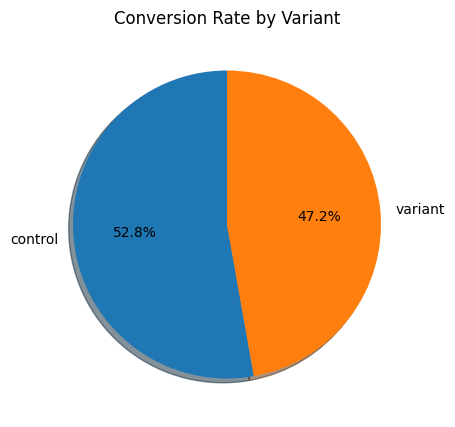

In [112]:
#calculate the conversion rate
conversion_rate = df.groupby('VARIANT_NAME').mean()['CONVERSION']

#plot chart for conversion rate
plt.figure(figsize=(5,5))
plt.pie(conversion_rate, labels=conversion_rate.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Conversion Rate by Variant')
plt.show()


In [113]:
#create a column named date and populate it with random dates, within a range of 30 days
import random
import datetime

start_date = datetime.date(2023, 10, 1)
end_date = datetime.date(2023, 9, 30)

date_list = []
for i in range(0, 10000):
    random_date = start_date + datetime.timedelta(days=random.randint(0, 29))
    date_list.append(random_date)

df['DATE'] = date_list
df.head()

,USER_ID,VARIANT_NAME,REVENUE,CONVERSION,DATE
0,737,variant,0.0,0,2023-10-29
1,2423,control,0.0,0,2023-10-28
2,9411,control,0.0,0,2023-10-03
3,7311,control,0.0,0,2023-10-24
4,6174,variant,0.0,0,2023-10-21


In [114]:

#convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

#truncate the date so we have columns for day, month and year and week
df['DAY'] = df['DATE'].dt.day
df['WEEK'] = df['DATE'].dt.isocalendar().week
df['MONTH'] = df['DATE'].dt.month
df['YEAR'] = df['DATE'].dt.year
df.head()

,USER_ID,VARIANT_NAME,REVENUE,CONVERSION,DATE,DAY,WEEK,MONTH,YEAR
0,737,variant,0.0,0,2023-10-29,29,43,10,2023
1,2423,control,0.0,0,2023-10-28,28,43,10,2023
2,9411,control,0.0,0,2023-10-03,3,40,10,2023
3,7311,control,0.0,0,2023-10-24,24,43,10,2023
4,6174,variant,0.0,0,2023-10-21,21,42,10,2023


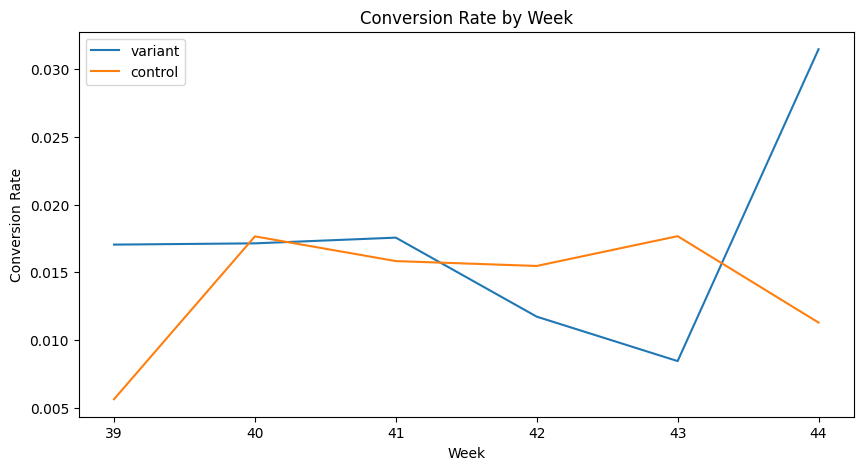

In [115]:
#calculate the conversion rate by week
conversion_rate_by_week = df.groupby(['VARIANT_NAME', 'WEEK']).mean()['CONVERSION']

#plot into a line chart
plt.figure(figsize=(10,5))
plt.plot(conversion_rate_by_week['variant'], label='variant')
plt.plot(conversion_rate_by_week['control'], label='control')
plt.legend()
plt.title('Conversion Rate by Week')
plt.xlabel('Week')
plt.ylabel('Conversion Rate')
plt.show()


In [116]:
conversion_rate_by_week_list_variant = conversion_rate_by_week['variant'].to_list()
conversion_rate_by_week_list_control = conversion_rate_by_week['control'].to_list()

In [117]:
# Model Beta Distribution from sample means (conversion_rate_by_week_list_variant & conversion_rate_by_week_list_control)

prior_alpha, prior_beta, _, _ = beta.fit(conversion_rate_by_week_list_variant, floc=0, fscale=1)


In [119]:
#get stats

NUM_WEEKS = 4
experiment_data = conversion_rate_by_week_list_variant[-NUM_WEEKS:]
control = conversion_rate_by_week_list_control[-NUM_WEEKS:]
treatment = conversion_rate_by_week_list_variant[-NUM_WEEKS:]

control_conversion_percentage = np.mean(control)
treatment_conversion_percentage = np.mean(treatment)
lift = (treatment_conversion_percentage - control_conversion_percentage) / control_conversion_percentage

print(f'Treatment Conversion Rate: {treatment_conversion_percentage}%')
print(f'Control Conversion Rate: {control_conversion_percentage}%')
print(f'Lift: {lift}%')

Treatment Conversion Rate: 0.017300290455110192%
Control Conversion Rate: 0.015067681704860912%
Lift: 0.14817201438022337%


In [121]:
control_converted = np.sum(control)
treatment_converted = np.sum(treatment)

control_non_converted = len(control) - control_converted
treatment_non_converted = len(treatment) - treatment_converted

#update prior parameters with experiment conversion rates
posterior_alpha = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)
posterior_treatment = beta(prior_alpha + control_converted, prior_beta + control_non_converted)

#sample from posterior 
control_samples = posterior_alpha.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)

print(f'Probability that treatment is better than control: {probability * 100}%')

Probability that treatment is better than control: 51.9%


In [136]:
lift_percentage = (treatment_samples - control_samples) / control_samples
print(f'Probability that we are seeing a 2% Lift: {round(np.mean((lift_percentage) > 2) * 100, 2)}%')

Probability that we are seeing a 2% Lift: 2.2%
